# Cloud Segmentation with Meteors


This notebook presents the methods from the `meteors` package that can be used for explaining the remote sensing models implementing the segmentation problem. In the notebook, we will walk through:
- Reformulation of the segmentation problem into regression
- LIME explanations
- Gradient-based explanations on the example of Integrated Gradients


The objective of a model, targeting such a task, is to divide the input image into coherent spatial regions. In this case, we will focus on *cloud segmentation* for multispectral imagery - the explained model will simply divide the input image into cloud or clean (cloudless) areas.

We'll use the `UNetMobV2_V1` model to perform the cloud segmentation process, which is based on research presented in the paper [CloudSEN12: A Global Dataset for Semantic Understanding of Cloud and Cloud Shadow in Sentinel-2](https://www.nature.com/articles/s41597-022-01878-2).


**Note:** Before running this notebook, make sure to install all the required libraries used in the notebook. It should be sufficient to install the newest version of the package meteors from PyPI, as it carries all the required dependencies. This can be done with a single line:

```pip install meteors```

 In some cases, however, a specific setup on your machine might require installing some additional ones. The cloudsen12_models module contains all the code needed for additional preprocessing and model loading. You can download it directly from the [Vignettes in the `meteors` repository](https://github.com/xai4space/meteors/tree/main/examples/segmentation).

## Table of Contents
- [0. Install and Import Dependencies](#0-install-and-import-dependencies)
- [1. Loading the Model](#1-loading-the-model)
- [2. Loading Sample Images](#loading-sample-images)
- [3. Interpreting the Model](#3-interpreting-the-model)
  - [3.1. Interpreting the Model with LIME](#31-interpreting-the-model-with-lime)
  - [3.2. Interpreting the Model with Gradient Methods](#32-interpreting-the-model-with-gradient-methods)

## 0. Install and Import Dependencies

To be able to run this notebook, you need to install the library `segmentation_models_pytorch` in version no lower than `0.0.3`. This can be done with a single line, if you use `pip` as your package manager:

In [ ]:
%pip install segmentation_models_pytorch>=0.0.3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import meteors as mt
import torch

import meteors.visualize as vis

c:\Users\tymot\miniconda3\envs\meteors-tutorials\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading the Model

We'll use a modified version of the `UNetMobV2_V1` model from the `cloudsen12_models` module, which contains code sourced from github repository [xai4space/cloudsen12_models](https://github.com/xai4space/cloudsen12_models/), where you can find a modification of the original *UNetMobV2_V1* model implementation, which was slighlty adjusted for the PyTorch inputs and outputs and have reduced dependencies. This implementation has been adapted to work seamlessly with PyTorch inputs and outputs, while preserving the gradients and have reduced external dependencies.


In [3]:
from cloudsen12_models import cloudsen12

Firstly, let's set the random seed for reproducibility of the results

In [4]:
torch.manual_seed(44)
np.random.seed(44)

In [5]:
model = cloudsen12.load_model_by_name(name="UNetMobV2_V1", weights_folder="cloudsen12_models")
cloudsen12_segment_interpretation = ["clear", "Thick cloud", "Thin cloud", "Cloud shadow"]

c:\Users\tymot\Documents\praca\pineapple\meteors\examples\segmentation\cloudsen12_models\cloudsen12.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.loa

## 2. Loading Sample Images
## Loading the images

To faciliate the analysis and allow for better reproduction of the examples, the images used in this notebook are already preprocessed and ready to be segmented. The original image is sourced from the Google Earth Engine, from a *COPERNICUS/S2_HARMONIZED* collection and a *S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941* tile. 

The image was later preprocessed according to the code from [this notebook](https://github.com/IPL-UV/cloudsen12_models/blob/main/notebooks/run_in_gee_image.ipynb).

In [6]:
img = np.load("data/0.npz")["img"]

with open("data/wavelenghts.txt", "r") as f:
    sentinel_central_wavelengths = f.readline()
sentinel_central_wavelengths = [float(wave.strip()) for wave in sentinel_central_wavelengths.split(",")]

The meteors package provides an easy-to-use wrapper for `HSI` hyperspectral (and multispectral) images. To take full advantage of the wrapper's potential, we also need to include wavelengths of the object. 

The `HSI` data object can be easily visualized in RGB format.

In [7]:
hsi = mt.HSI(image=img, wavelengths=sentinel_central_wavelengths)

The original image is stored in the `image` attribute of the `HSI` object. Let's now test that the model can predict cloud segmentation on this image.

In [8]:
cloudmask = model.predict(hsi.image.unsqueeze(0))
cloudmask_hard_labels = torch.argmax(cloudmask, dim=1).type(torch.uint8)

The model output is a 4-channel tensor, where each channel represents a different class (soft labels). To get the final prediction, we need to use the `argmax` function to select the class with the highest probability.

In [9]:
cloudmask_hard_labels.shape

torch.Size([1, 622, 916])

Let's now visualize the model's prediction on the image.

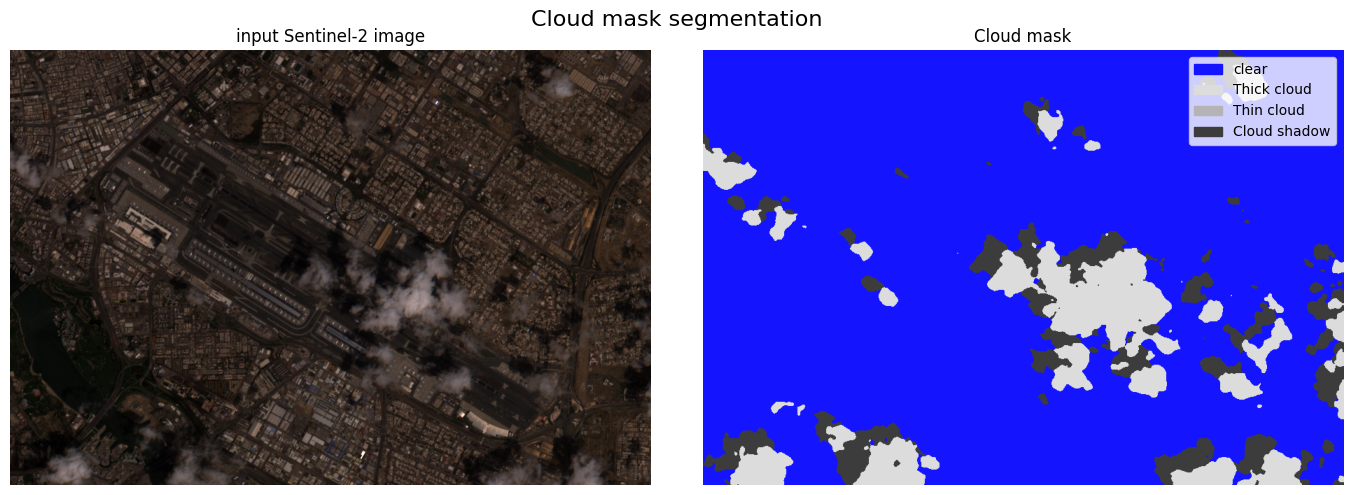

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels.squeeze(), ax[1])
ax[1].set_title("Cloud mask")

vis.visualize_hsi(hsi, ax[0])
ax[0].set_title("input Sentinel-2 image")
fig.suptitle("Cloud mask segmentation", fontsize=16)

plt.show()

## 3 Interpreting the Model


The XAI methods implemented in the `meteors` package are designed for creating explanations for single-output problems, usually classification or regression. However, the segmentation models ouput multi-dimensional arrays, which cannot be analyzed easily by standard XAI methods. 


Fortunately, using a simple trick, we can create a low-dimentional output, by postprocessing the model's outputs. The postprocessing is usually aggregation performed by the region type, and in short, it comes down to simply counting pixels in each class. The `meteors` package provides a simple aggregation function `agg_segmentation_postprocessing` for this purpose, but feel free to experiment with other aggregation functions as well.

In [9]:
from meteors.utils import agg_segmentation_postprocessing

postprocessing = agg_segmentation_postprocessing(
    soft_labels=True,
    classes_numb=len(cloudsen12_segment_interpretation),
    class_axis=1,
)

The `agg_segmentation_postprocessing` function requires several parameters to properly handle different model outputs. Let's examine each parameter in detail:

- `soft_labels` parameter specifies whether the analyzed model outputs soft labels (probabilities of pixels belonging to each class) or hard labels (one class is assigned for each pixel). In case the model uses hard labels, the shape of the output should be 3 dimensional, with batch size as its first dimension. The output's shape should be 4 dimensional otherwise
- `classes_numb` is a parameter specifying how many classes are predicted by the model
- `class_axis` used only for soft labels. It specifies on which axis the class dimension is. If the `class_axis` equals to 0, then batch size should be at the second dimension.

Let's now use the `agg_segmentation_postprocessing` function to convert the model's output into a single numerical output. We'll then use this output to interpret the model with meteors' XAI methods.

In [10]:
aggregated_segmentation_mask = postprocessing(cloudmask)
aggregated_segmentation_mask

tensor([[461402.5625,  50634.7188,      0.0000,  33250.5391]],
       grad_fn=<SumBackward1>)

In [11]:
cloudmask.shape

torch.Size([1, 4, 622, 916])

In [12]:
aggregated_segmentation_mask.shape

torch.Size([1, 4])

Text(0.5, 0, 'Class')

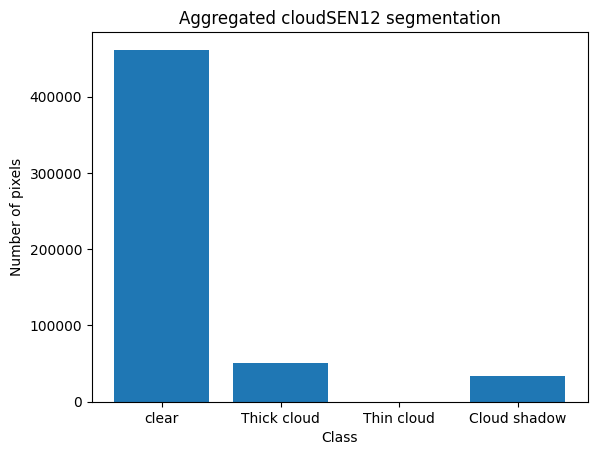

In [13]:
plt.bar(np.arange(4), aggregated_segmentation_mask.detach().squeeze())
plt.xticks(np.arange(4), cloudsen12_segment_interpretation)
plt.title("Aggregated cloudSEN12 segmentation")
plt.ylabel("Number of pixels")
plt.xlabel("Class")

The `agg_segmentation_postprocessing` function is used to aggregate the model's pixel-wise predictions into a single numerical output. An important thing to note is that the sum of the aggregated values is not necessarily needs to equal to the number of pixels in the image, in case there are soft labels used. In that case, the aggregation function takes the probabilities of the argmax class for each pixel and sums them up. 

Now that we tested how to aggregate the model's output, we can proceed with the explanation. One last thing is to properly initialize the model inside the `meteors` environment. This is done by creating an object that contains all the necessary information to perform an explanation, which is:

- the forward function of the model
- the problem type, here `segmentation`
- in case the problem type is `segmentation`, the required parameter is the `postprocessing_output`, which is a method for aggregating the outputs as we did before.

In [14]:
explainable_model = mt.models.ExplainableModel(
    model.predict, problem_type="segmentation", postprocessing_output=postprocessing
)

And let's check that model forward function now returns the aggregated output with the gradients.

In [15]:
aggregated_segmentation_mask = explainable_model(hsi.image.unsqueeze(0))
aggregated_segmentation_mask

tensor([[461402.5625,  50634.7188,      0.0000,  33250.5391]],
       grad_fn=<SumBackward1>)

### 3.1 Interpreting the Model with LIME

We'll use the [LIME (Local Interpretable Model-agnostic Explanations)](https://dl.acm.org/doi/abs/10.1145/2939672.2939778) method to understand our model's behavior. For a comprehensive understanding of LIME and its implementation in `meteors`, refer to our [LIME tutorial](https://xai4space.github.io/meteors/latest/tutorials/lime/).

The intepretable model of LIME is a linear model LASSO model with a regularization parameter of 0.001.

In [16]:
interpretable_model = mt.models.SkLearnLasso(alpha=0.01)
lime = mt.attr.Lime(explainable_model=explainable_model, interpretable_model=interpretable_model)

#### Spatial analysis

Firstly, let us verify, which image regions contribute the most to the specific class predictions - we will perform spatial analysis of the model. LIME explanation method requires the input feature space to be low-dimensional and to satisfy this condition, we will create a LIME segmentation mask, which will help understanding LIME which regions are more relevant for the cloudsen model. 

Now, we will create the LIME segmentation mask, and later create attributions for the class 0 - the clean (cloudless) areas.

We will use the `SLIC` algorithm to generate this mask. The `SLIC` algorithm is a superpixel segmentation method that groups pixels into regions based on their similarity.

**Note:** The segmentation mask created for the LIME method is something completely different from the output created by the cloudsen model.


In [17]:
lime_seg_mask = lime.get_segmentation_mask(hsi, segmentation_method="slic", num_interpret_features=50)

method `get_spatial_attributes` apart from the 3 required fields:

- `hsi` - the hyperspectral image data
- `mask` - the segmentation mask
- `target` - the target index class to be analyzed: 0 for clear

takes as well few optional hyperparameters of explanations. Where one of the most important is:

- `n_samples` - it is a number of the generated artificial samples on which the linear model is trained. The larger number of samples, the explanations produced by the linear model are usually better, since its predictions should better mimic the predictions of the explained model. However, the larger `n_samples` the longer attribution takes to be performed

In [18]:
attributes = lime.get_spatial_attributes(
    hsi,
    target=0,
    segmentation_mask=lime_seg_mask,
    n_samples=100,
)

2024-11-21 01:19:46.869 | WARNING  | meteors.attr.explainer:device:143 - Not a torch model, setting device to cpu


To validate how well the trained surrogate model predicts the explained model outputs, we can use the `score` attribute of the explanations:

In [19]:
print(f"Score of the attribution: {attributes.score}")

Score of the attribution: 0.9968178272247314


Score of the LIME attribution is the $R^2$ score of the interpretable model predictions. The value of this parameter is between 0 and 1, the larger the value the better the explanations. We can see that this explanation is particulary good.

And let's now visualize the LIME spatial explanation.

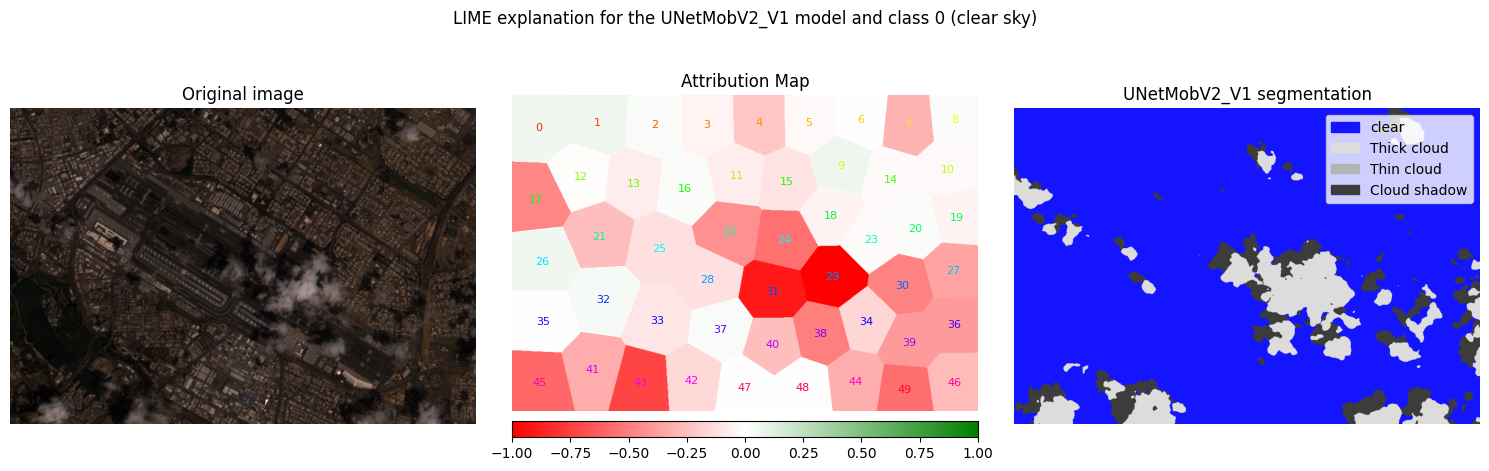

In [20]:
fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 0 (clear sky)")

ax[2].clear()
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels, ax=ax[2])
ax[2].set_title("UNetMobV2_V1 segmentation")
fig.tight_layout()
plt.show()

The figure above is a slight modification of the baseline figure provided by the `meteors` package, which summarizes the spatial analysis for a specific image. 

The colors in the attribution map, presented in the center, have the following meaning:

- **Red**: This superpixel is negatively correlated with the input. In our case, it means that the presence of this superpixel contributed to lowering the value for the target class `0` (clear terrain).
- **White**: This segment did not have a significant impact on the output.
- **Green**: This superpixel is positively correlated with the output. Its presence increases the value for the class `0`.


As we can see in the figure above, the most relevant regions are those with the actual clouds. This observation is confirmation that the model actually works properly - in case the regions with high absolute attribution values are perturbed, model perfoms the segmentation worse.

Score of the attribution: 0.9983850717544556


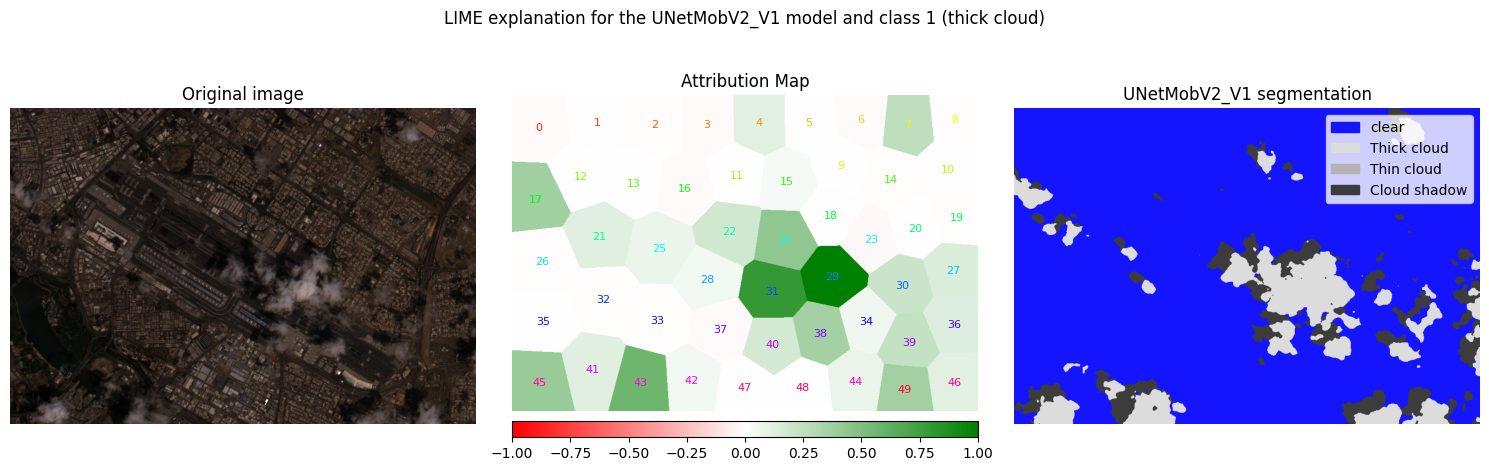

In [21]:
attributes = lime.get_spatial_attributes(hsi, target=1, segmentation_mask=lime_seg_mask, n_samples=100)

fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 1 (thick cloud)")
ax[2].clear()
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels, ax=ax[2])
ax[2].set_title("UNetMobV2_V1 segmentation")
print(f"Score of the attribution: {attributes.score}")
fig.tight_layout()
plt.show()

For the class thick cloud, the situation is very similar. Again the regions with the actual clouds contribute the most to the prediction. This time, the attribution is positive, which suggests that modification in these regions increases the number of pixels classified as thick cloud class. This result is consistent with the previous one.

#### Spectral analysis

Now, we will perform spectral analysis, which focuses on different bands and their impact on the models predictions. For the multispectral images, we can analyze the impact of all the bands seperately, or group them into superbands. Firstly, let's investigate, which of the bands are the most important.

To do so, we will need to create a band mask - a similar object to the lime segmentation mask, but with aggregations in the spectral dimension.

In [22]:
band_indices = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B08": 7,
    "B8A": 8,
    "B09": 9,
    "B10": 10,
    "B11": 11,
    "B12": 12,
}

band_mask, band_names = lime.get_band_mask(hsi, band_indices=band_indices)
attributes = lime.get_spectral_attributes(hsi, target=0, band_mask=band_mask, band_names=band_names, n_samples=100)

Once the attributions are calculated, we can easily visualize them as previously but now focusing on the spatial explanations.

Score of the attribution: 0.45737916231155396


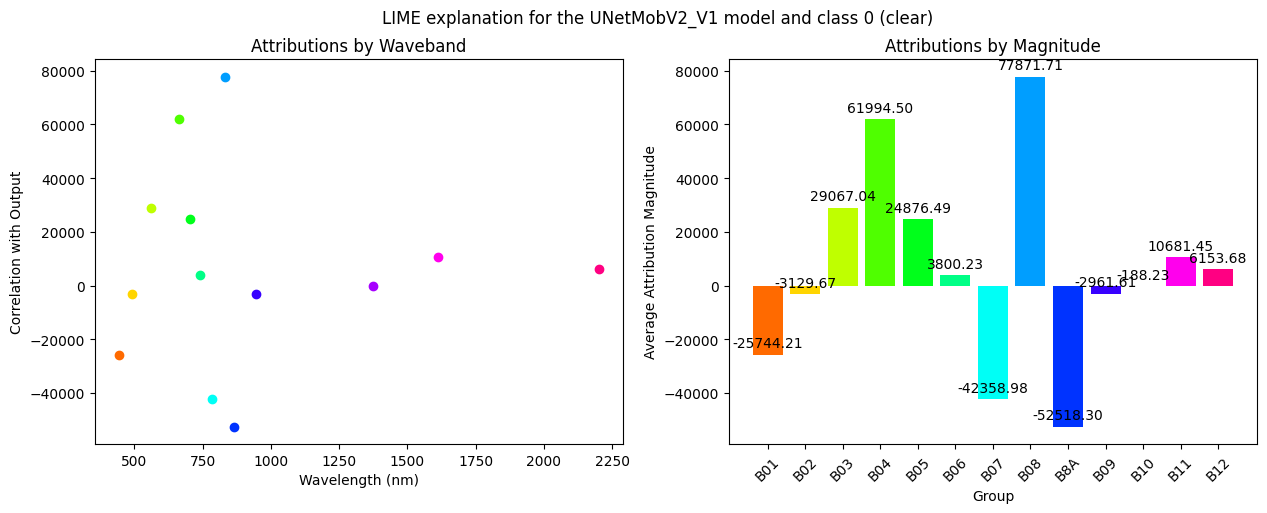

In [23]:
mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 0 (clear)")
plt.show()

In the chart above, we can see which of the specified bands contribute the most to the model's prediction. On the left, we can exactly see the correlation with the output and the bands wavelenghts, whereas the plot on the right allows to easily compare the attribution values. 

As of the [paper](https://www.nature.com/articles/s41597-022-01878-2) on the dataset CloudSEN12 used in model training, for segmentation of the class *clear*, the experts used primarily the visible bands: B02, B03, B04, and NIR band B08. This is consisistent with our explanations, even though the score of the explanations is low.

Similarily, as in the case of the spatial explanations, we can also analyze easily different classes, by passing a different target value to the function. In this case, we will analyze the thick cloud class (index 1).

Score of the attribution: 0.32696086168289185


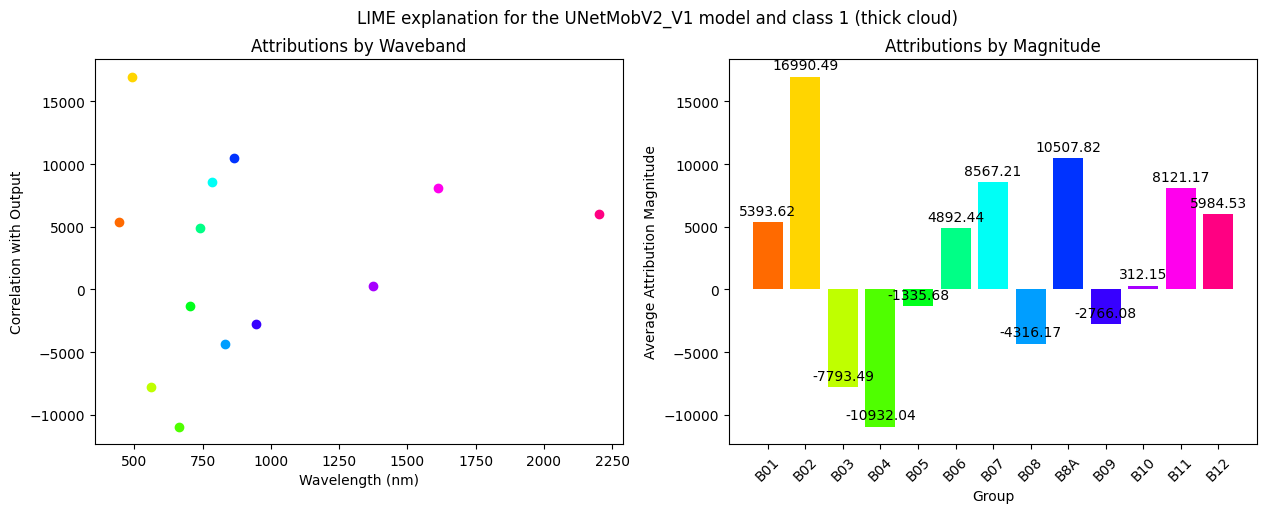

In [24]:
attributes = lime.get_spectral_attributes(
    hsi,
    target=1,
    band_mask=band_mask,
    band_names=band_names,
    n_samples=200,
    perturbations_per_eval=4,
)

mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 1 (thick cloud)")
plt.show()

### 3.2. Interpreting the Model with Gradient Methods

To further understand the model's behavior, we can use any other attribution method implemented in the package. More detailed description of such methods can be found in [vignette on various attribution methods](https://xai4space.github.io/meteors/latest/tutorials/attr_showcase/). These methods allows to analyze how the model's predictions change with respect to the input image, usually providing a pixel-wise attribution of the model's output, showing which pixels are the most influential in the model's decision-making process. 

In this tutorial, we will use one of many implemented methods in the package - the Integrated Gradients, a powerful gradient-based attribution technique with methematical foundations. For detailed description of the method, please refer to the [original paper](https://doi.org/10.48550/arXiv.1703.01365).

In [25]:
ig = mt.attr.IntegratedGradients(explainable_model=explainable_model)
attributes = ig.attribute(hsi, target=0, n_steps=10)

Convergence of the integrated gradients: None


Text(0.5, 0.98, 'Integrated Gradient explanation for the UNetMobV2_V1 model and class 0 (clear)')

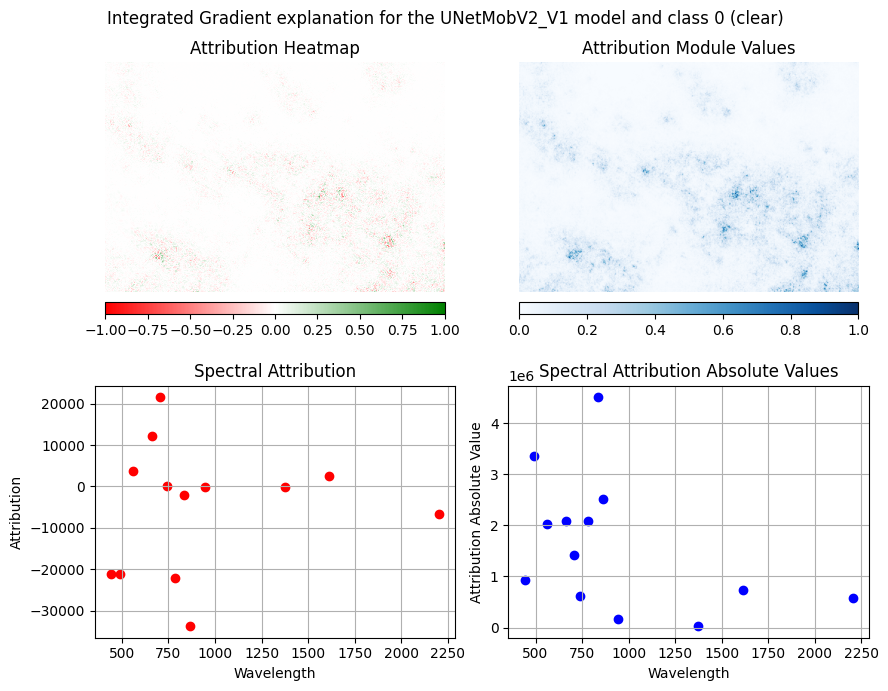

In [26]:
fig, ax = vis.visualize_attributes(attributes)
print(f"Convergence of the integrated gradients: {attributes.score}")
fig.suptitle("Integrated Gradient explanation for the UNetMobV2_V1 model and class 0 (clear)")

Even though the Integrated Gradient methods hasn't converged, we can read the attributions and analyze the model. The attribution visualization provides two complementary perspectives on model behavior:

**Top Images - Spatial Attribution**

- Shows spatialy which regions in the image influence model predictions
- Helps identify areas crucial for detecting specific features (e.g., cloud edges or clear sky)
- Intensity indicates strength of influence on the prediction

**Bottom Images - Spectral Attribution**

- Reveals which spectral bands are most important for predictions
- Highlights bands that provide strong cloud/ground contrast
- Helps understand which wavelengths are key for feature discrimination

The similar attributions can be calculated for another classes, e.g. cloud shadow.

Convergence of the integrated gradients: None


Text(0.5, 0.98, 'Integrated Gradient explanation for the UNetMobV2_V1 model and class 3 (cloud shadow)')

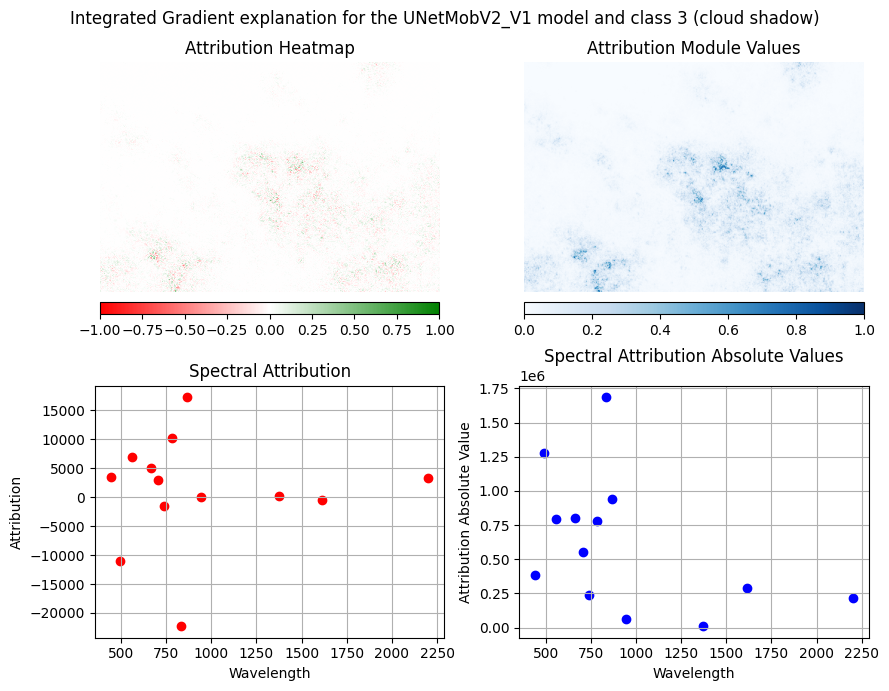

In [27]:
attributes = ig.attribute(hsi, target=3, n_steps=10)
print(f"Convergence of the integrated gradients: {attributes.score}")
fig, ax = vis.visualize_attributes(attributes)
fig.suptitle("Integrated Gradient explanation for the UNetMobV2_V1 model and class 3 (cloud shadow)")

Looking at the attribution map for class 3 (cloud shadow), we can observe a strong correlation between areas of actual cloud shadows in the original image and regions of high attribution values. Additionaly, we see that in the spectral context the most important bands are the first ones, wheras the further bands are not as important.
